<a href="https://colab.research.google.com/github/alegbeleye/IAT360_CV_ASSIGNMENT/blob/main/IAT360_CV_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import json
import glob
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.widgets import RectangleSelector
import numpy as np
from tqdm import tqdm
import pandas as pd
from shapely.geometry import box as shapely_box

In [5]:
classes=[
    "0",
    "1",
    "2",
    "3",
    "4",
    "5",
    "6",
    "7",
    "8",
    "9",
    "A",
    "B",
    "C",
    "D",
    "E",
    "F",
    "G",
    "H",
    "I",
    "K",
    "L",
    "M",
    "N",
    "O",
    "P",
    "Q",
    "R",
    "S",
    "T",
    "U",
    "V",
    "X",
    "Y",
    "Z",
    "a",
    "b",
    "c",
    "d",
    "e",
    "f",
    "g",
    "h",
    "i",
    "j",
    "k",
    "l",
    "m",
    "n",
    "o",
    "p",
    "q",
    "r",
    "s",
    "t",
    "u",
    "v",
    "w",
    "x",
    "y",
    "z",
  ]

In [6]:
def decode_word(path: str):
  word=""
  bounding_boxes = []
  try:
      with open(path, "r", encoding="utf-8") as f:
          lines = f.readlines()
          for i in range(len(lines)):
              lines[i] = lines[i].strip().split(" ")
      # decode word by each letter
      for line in lines:
          letter = classes[int(line[0])]
          bounding_box = [float(l)for l in line[1:]]
          word += letter
          bounding_boxes.append({"char":letter, "bbox":bounding_box})
      return word, bounding_boxes
  except FileNotFoundError:
      raise
  except Exception as e:
      raise RuntimeError(f"Error reading {path}: {e}") from e

In [7]:
DATA_ROOT ="/content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project"
IMAGES_PATH = '/content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/Doctors prescriptions handwriting.v1i.yolov8 2/train/*/*.jpg'
LABELS_PATH = '/content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/Doctors prescriptions handwriting.v1i.yolov8 2/train/*/*.txt'

image_list = sorted(glob.glob(IMAGES_PATH))
label_list = sorted(glob.glob(LABELS_PATH))


data = []
data_bbx = []
for i in range(len(image_list)):
  word, bbxs = decode_word(label_list[i])
  data.append({"image": image_list[i], "label": label_list[i], "word":word})
  data_bbx.append({"image": image_list[i], "label": label_list[i], "word":word, "bboxs":bbxs})

df = pd.DataFrame(data)
df.head()

,image,label,word
0,/content/drive/MyDrive/Tutorials/Datasets/IAT ...,/content/drive/MyDrive/Tutorials/Datasets/IAT ...,Xpa
1,/content/drive/MyDrive/Tutorials/Datasets/IAT ...,/content/drive/MyDrive/Tutorials/Datasets/IAT ...,Xpa
2,/content/drive/MyDrive/Tutorials/Datasets/IAT ...,/content/drive/MyDrive/Tutorials/Datasets/IAT ...,Anuva50
3,/content/drive/MyDrive/Tutorials/Datasets/IAT ...,/content/drive/MyDrive/Tutorials/Datasets/IAT ...,Paricel
4,/content/drive/MyDrive/Tutorials/Datasets/IAT ...,/content/drive/MyDrive/Tutorials/Datasets/IAT ...,Progut20mg


In [8]:
# Cell: draw YOLO-format GT boxes on an image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from pathlib import Path

def yolo_line_to_xyxy(line, img_w, img_h):
    # line: "class x_center y_center width height" (normalized)
    parts = line.strip().split()
    if len(parts) < 5:
        raise ValueError("Expected 5 values in YOLO line: class xc yc w h")
    cls = parts[0]
    xc, yc, w, h = map(float, parts[1:5])
    x1 = (xc - w/2.0) * img_w
    y1 = (yc - h/2.0) * img_h
    x2 = (xc + w/2.0) * img_w
    y2 = (yc + h/2.0) * img_h
    # clamp + int
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(img_w - 1, x2), min(img_h - 1, y2)
    # ensure ordering
    if x2 < x1: x1, x2 = x2, x1
    if y2 < y1: y1, y2 = y2, y1
    return int(x1), int(y1), int(x2), int(y2), int(cls)

def draw_yolo_labels_on_image(image_path, label_path=None, show=True):
    img = Image.open(image_path).convert('RGB')
    W, H = img.size
    fig, ax = plt.subplots(1, figsize=(10,6))
    ax.imshow(img)
    ax.axis('off')

    # read label file (optional) - if not provided, just show image
    if label_path and Path(label_path).exists():
        with open(label_path, 'r') as f:
            for line in f:
                try:
                    x1,y1,x2,y2,cls = yolo_line_to_xyxy(line, W, H)
                except Exception as e:
                    print("Skipping line, parse error:", e, "->", line.strip())
                    continue
                rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2,
                                         edgecolor='lime', facecolor='none')
                ax.add_patch(rect)
                ax.text(x1, max(0,y1-8), str(cls), fontsize=10, color='yellow',
                        bbox=dict(facecolor='black', alpha=0.6))
    if show:
        plt.show()

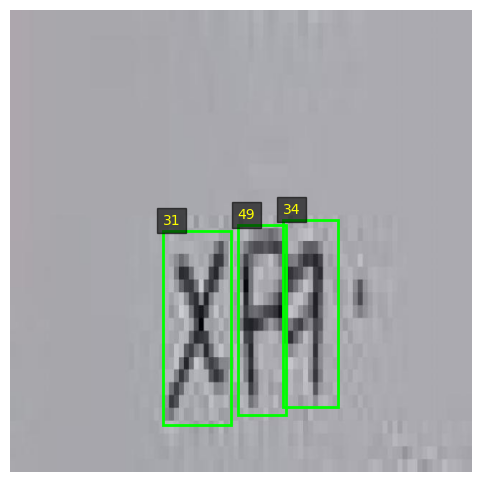

In [9]:
draw_yolo_labels_on_image(image_list[0], label_path=label_list[0], show=True)

# Task
Train a YOLO model on a dataset to detect letters in images.

## Install necessary libraries

### Subtask:
Install the required libraries for YOLO training, such as `ultralytics`.


**Reasoning**:
The subtask is to install the `ultralytics` library. This can be done using the pip package manager.



In [10]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 67.1 MB/s eta 0:00:00


## Prepare data for yolo

### Subtask:
Ensure your dataset is in the correct YOLO format, with images and corresponding text files containing bounding box annotations and class labels. Based on the previous steps, it seems like the data is already in this format, but we should confirm.


## Configure yolo model

### Subtask:
Choose a YOLO model variant and configure its parameters for training, including specifying the number of classes, input image size, and training hyperparameters.


**Reasoning**:
Import the YOLO class, load a pre-trained model, and define the data dictionary for training.



In [27]:
from ultralytics import YOLO
import yaml

# Load a pre-trained YOLO model
model = YOLO()

# Define data dictionary
data = {
    'train': os.path.join(DATA_ROOT, 'Doctors prescriptions handwriting.v1i.yolov8 2', 'train'),
    'val': os.path.join(DATA_ROOT, 'Doctors prescriptions handwriting.v1i.yolov8 2', 'valid'),
    'nc': len(classes),
    'names': classes
}

# Define the path to save the YAML file
yaml_path = os.path.join(DATA_ROOT, 'dataset.yaml')

# Save the data dictionary to a YAML file
with open(yaml_path, 'w') as f:
    yaml.dump(data, f)

print(f"Dataset configuration saved to {yaml_path}")

Dataset configuration saved to /content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/dataset.yaml


## Train the yolo model

### Subtask:
Train the YOLO model on your prepared dataset using the configured parameters.


**Reasoning**:
Train the YOLO model using the specified parameters: 25 epochs, image size 640, patience 5, and batch size 16.



In [22]:
!rm -rf /content/runs

In [28]:
# Use the path to the YAML file for training
results = model.train(data=yaml_path, epochs=25, imgsz=640, patience=5, batch=16, project=DATA_ROOT, name="training")  # custom directory


Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=training, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap

In [48]:
# Load the trained model
model = YOLO() # Assuming the best model is saved here

In [49]:

def run_sample_test(checkpoint_path):

  # Choose a sample image to test
  sample_image_path = image_list[0] # Using the first image from the list as an example
  sample_image_path2 = image_list[10] # Using the first image from the list as an example

  # Perform inference
  results = model(sample_image_path)
  results2 = model(sample_image_path2)

  # Visualize the results
  results[0].show()
  results2[0].show()



image 1/1 /content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/Doctors prescriptions handwriting.v1i.yolov8 2/train/images/158644895_882858708940191_8856443046584616079_n-3-_jpg.rf.2ee8d19042032adb47ea4c108383bf3c.jpg: 640x640 (no detections), 9.3ms
Speed: 1.7ms preprocess, 9.3ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/Doctors prescriptions handwriting.v1i.yolov8 2/train/images/20230513_000658-6-_jpg.rf.0a5585e6e087cd76a328adb0a3958a54.jpg: 640x640 1 F, 8.2ms
Speed: 1.5ms preprocess, 8.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


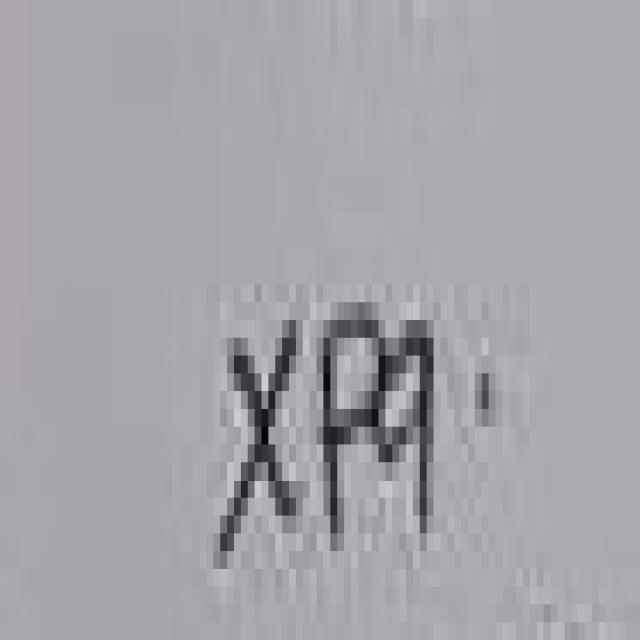

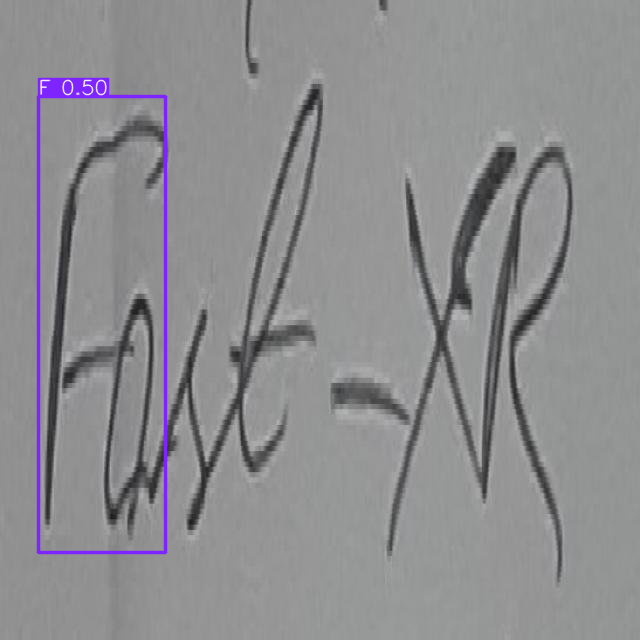

In [44]:
chk_pth = os.path.join(DATA_ROOT,'training/weights/best.pt')
run_sample_test(chk_pth)

### Run training for different epochs up by 20

In [39]:
results = model.train(data=yaml_path, epochs=40, imgsz=640, patience=5, batch=16, project=DATA_ROOT, name="training")  # custom directory

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/training/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=Fals


image 1/1 /content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/Doctors prescriptions handwriting.v1i.yolov8 2/train/images/158644895_882858708940191_8856443046584616079_n-3-_jpg.rf.2ee8d19042032adb47ea4c108383bf3c.jpg: 640x640 (no detections), 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/Doctors prescriptions handwriting.v1i.yolov8 2/train/images/20230513_000658-6-_jpg.rf.0a5585e6e087cd76a328adb0a3958a54.jpg: 640x640 1 F, 1 t, 8.2ms
Speed: 1.5ms preprocess, 8.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


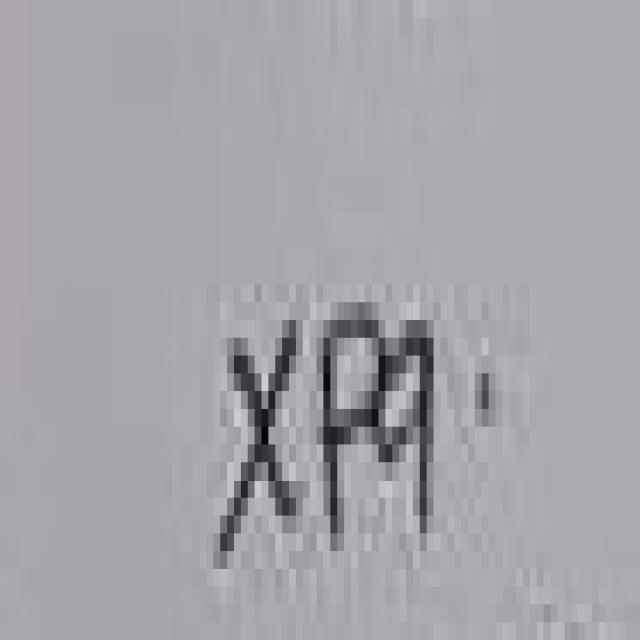

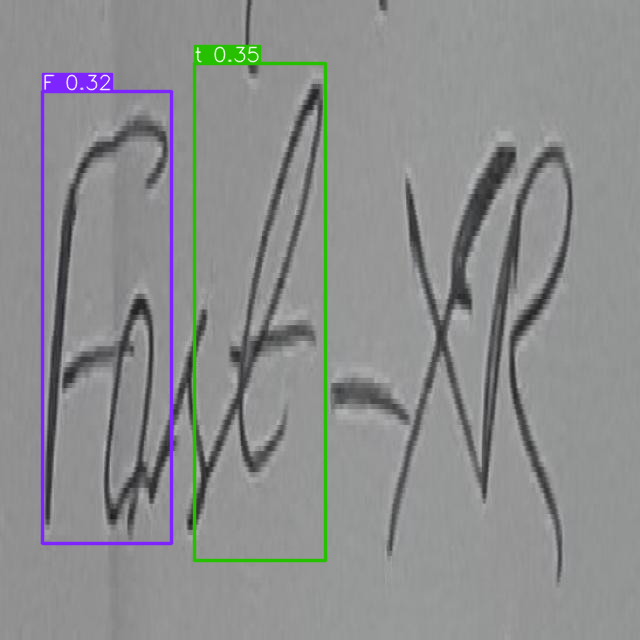

In [45]:
chk_pth = os.path.join(DATA_ROOT,'training2/weights/best.pt')
run_sample_test(chk_pth)

In [50]:
results = model.train(data=yaml_path, epochs=60, imgsz=640, patience=5, batch=16, project=DATA_ROOT, name="training")  # custom directory

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=training3, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overla


image 1/1 /content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/Doctors prescriptions handwriting.v1i.yolov8 2/train/images/158644895_882858708940191_8856443046584616079_n-3-_jpg.rf.2ee8d19042032adb47ea4c108383bf3c.jpg: 640x640 1 X, 1 x, 9.1ms
Speed: 1.8ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/Doctors prescriptions handwriting.v1i.yolov8 2/train/images/20230513_000658-6-_jpg.rf.0a5585e6e087cd76a328adb0a3958a54.jpg: 640x640 1 F, 1 R, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


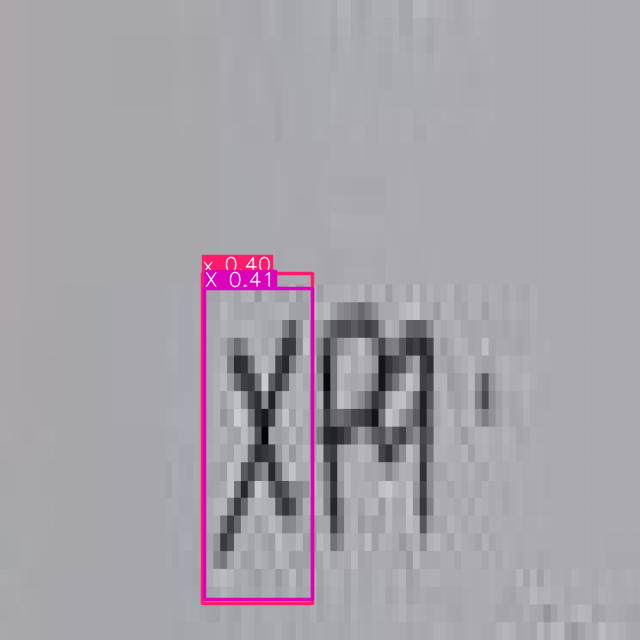

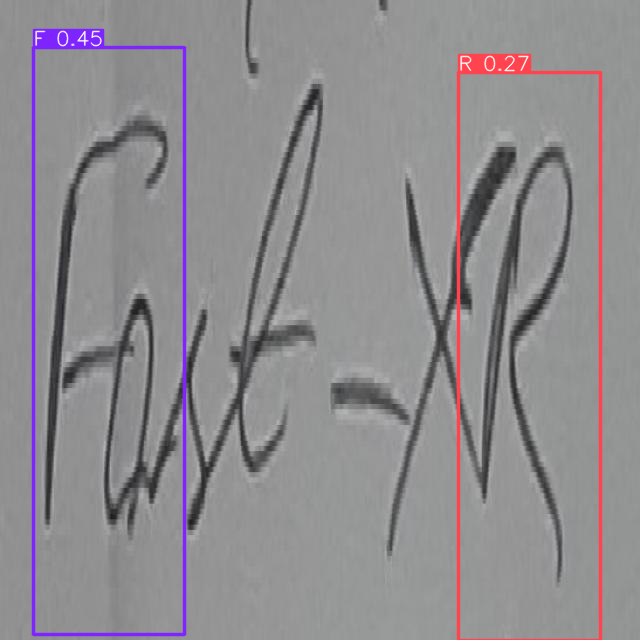

In [51]:
chk_pth = os.path.join(DATA_ROOT,'training3/weights/best.pt')
run_sample_test(chk_pth)

### Trying batch size of 8 for a more stable apprach - is gonna take longer though smh

#### giving it more patience to see if it actually remains still after 51 epochs (might be different since batch size also changed)

In [54]:
model = YOLO()
results = model.train(data=yaml_path, epochs=60, imgsz=640, patience=10, batch=8, project=DATA_ROOT, name="training")

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=training4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap


image 1/1 /content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/Doctors prescriptions handwriting.v1i.yolov8 2/train/images/158644895_882858708940191_8856443046584616079_n-3-_jpg.rf.2ee8d19042032adb47ea4c108383bf3c.jpg: 640x640 1 X, 1 x, 10.4ms
Speed: 2.3ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/Doctors prescriptions handwriting.v1i.yolov8 2/train/images/20230513_000658-6-_jpg.rf.0a5585e6e087cd76a328adb0a3958a54.jpg: 640x640 1 F, 1 R, 8.6ms
Speed: 1.6ms preprocess, 8.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


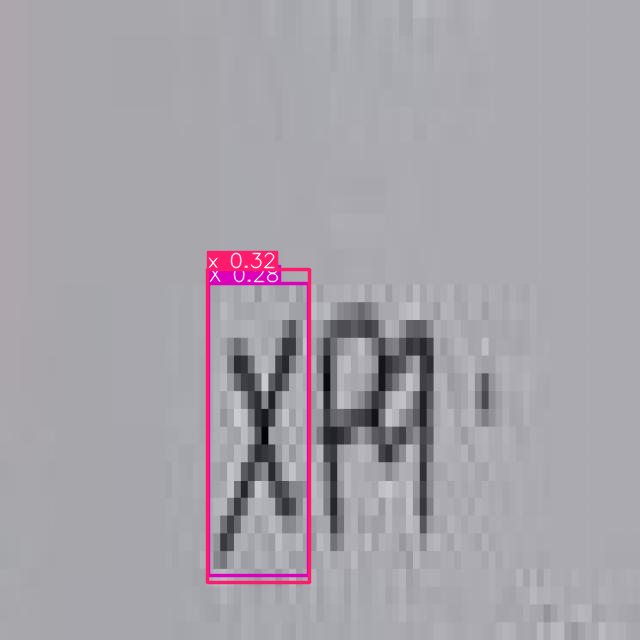

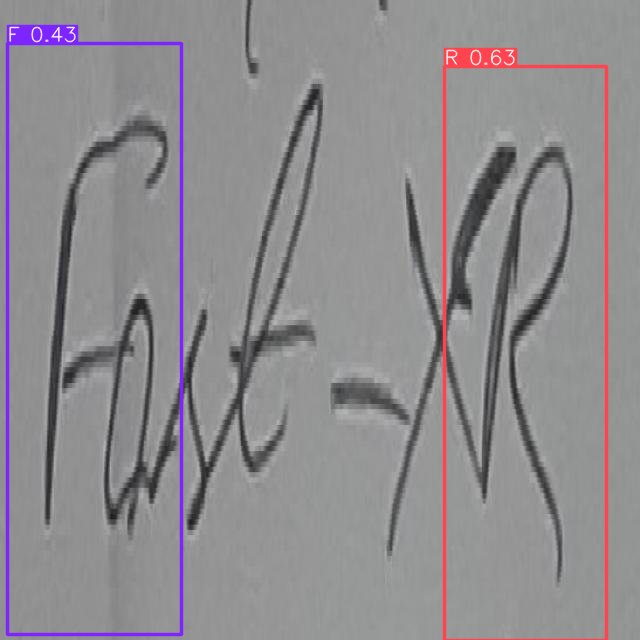

In [55]:
chk_pth = os.path.join(DATA_ROOT,'training4/weights/best.pt')
run_sample_test(chk_pth)

#### This approach seems to be working better im going to continue the training using the checkpoint from the last run.

In [56]:
last_checkpoint = os.path.join(DATA_ROOT,'training4/weights/best.pt')
model = YOLO(last_checkpoint)
results = model.train(data=yaml_path, epochs=40, imgsz=640, patience=10, batch=8, project=DATA_ROOT, name="training")

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/training4/weights/last.pt, momentum=0.937, mosaic=1.0, multi_scale=Fals


image 1/1 /content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/Doctors prescriptions handwriting.v1i.yolov8 2/train/images/158644895_882858708940191_8856443046584616079_n-3-_jpg.rf.2ee8d19042032adb47ea4c108383bf3c.jpg: 640x640 1 X, 1 p, 1 x, 10.7ms
Speed: 1.9ms preprocess, 10.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/Doctors prescriptions handwriting.v1i.yolov8 2/train/images/20230513_000658-6-_jpg.rf.0a5585e6e087cd76a328adb0a3958a54.jpg: 640x640 1 F, 1 M, 1 R, 1 X, 3 as, 1 s, 1 t, 8.5ms
Speed: 1.4ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


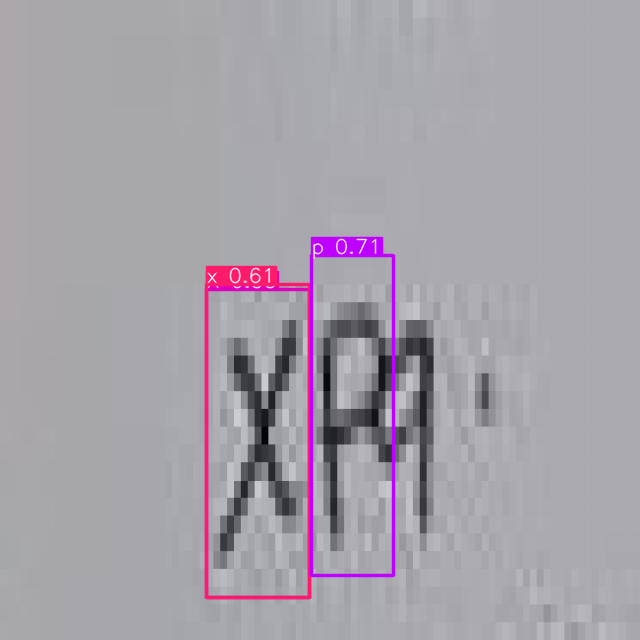

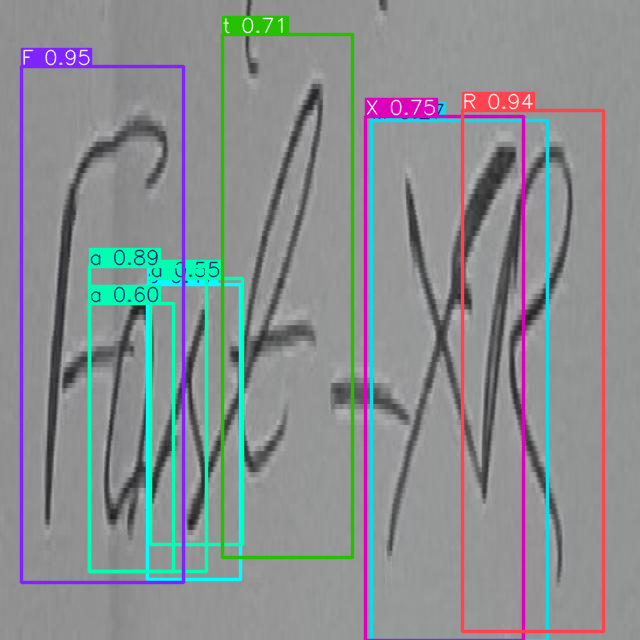

In [58]:
chk_pth = os.path.join(DATA_ROOT,'training5/weights/best.pt')
run_sample_test(chk_pth)

#### Model has improved significantly but loss still reducing (Continuing the training with last checkpoint)

In [59]:
last_checkpoint = os.path.join(DATA_ROOT,'training5/weights/best.pt')
model = YOLO(last_checkpoint)
results = model.train(data=yaml_path, epochs=40, imgsz=640, patience=10, batch=8, project=DATA_ROOT, name="training")

Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/dataset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/training5/weights/best.pt, momentum=0.937, mosaic=1.0, multi_scale=Fals


image 1/1 /content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/Doctors prescriptions handwriting.v1i.yolov8 2/train/images/158644895_882858708940191_8856443046584616079_n-3-_jpg.rf.2ee8d19042032adb47ea4c108383bf3c.jpg: 640x640 1 X, 1 p, 8.7ms
Speed: 2.0ms preprocess, 8.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/drive/MyDrive/Tutorials/Datasets/IAT 360 Computer Vision Project/Doctors prescriptions handwriting.v1i.yolov8 2/train/images/20230513_000658-6-_jpg.rf.0a5585e6e087cd76a328adb0a3958a54.jpg: 640x640 1 F, 1 R, 2 Xs, 2 as, 1 s, 1 t, 8.1ms
Speed: 1.6ms preprocess, 8.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


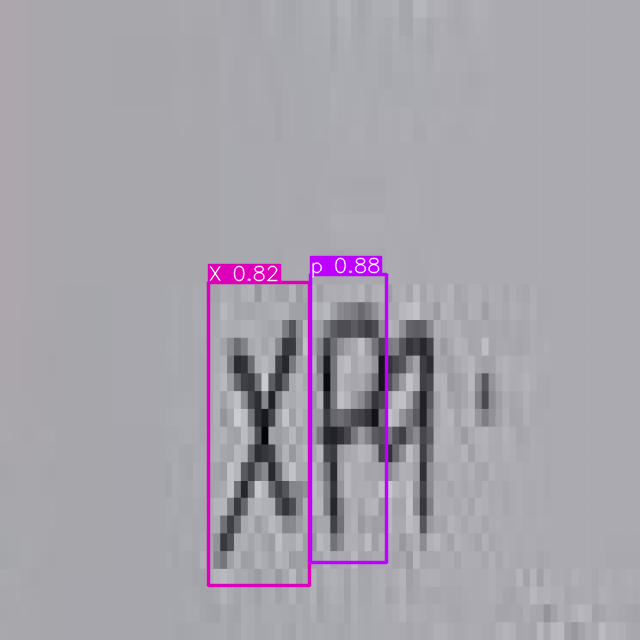

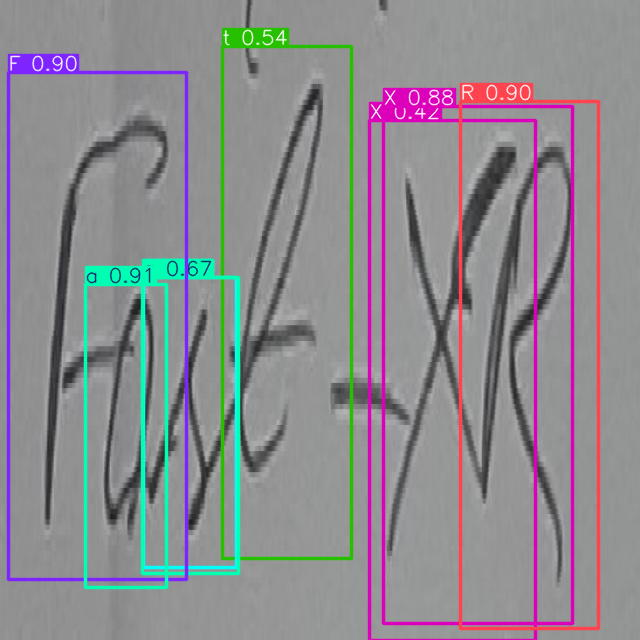

In [60]:
chk_pth = os.path.join(DATA_ROOT,'training6/weights/last.pt')
run_sample_test(chk_pth)